In [1]:
import json
import networkx as nx
from community import best_partition
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.ensemble import IsolationForest

In [4]:

def load_graph_from_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
    graph = nx.Graph()
    for node, attributes in data["nodes"]:
        graph.add_node(node, **attributes)
    for edge in data["edges"]:
        graph.add_edge(edge[0], edge[1], weight=edge[2]["weight"])
    return graph

# setup graph
graph = load_graph_from_json("graph_data.json")


In [5]:
# community detection
partition = best_partition(graph, weight="weight")
nx.set_node_attributes(graph, partition, "community")

In [6]:
# calculating anomalies
def detect_anomalies(graph, partition):
    anomalies = []
    weight_threshold = np.percentile(
        [data.get("weight", 1) for _, _, data in graph.edges(data=True)], 90) #detects anomalies by identifying edges with weights above the 90th percentile.
    for edge in graph.edges(data=True):
        weight = edge[-1].get("weight", 1)
        if weight > weight_threshold:
            anomalies.append({"source": f"{edge[0]} - {edge[1]}", "Weight": weight})
    return pd.DataFrame(anomalies)


In [7]:

anomalies_df = detect_anomalies(graph, partition)
anomalies_df_sorted = anomalies_df.sort_values(by="Weight", ascending=False)
print(anomalies_df_sorted)

                              source  Weight
20              yaacovn - ymthegoat2    1916
44              yanhob - armenianani    1830
42                yanhob - juniorpov    1576
19  yaacovn - youweremybrotheranakin    1511
57         the_machine04 - dimailuka    1445
..                               ...     ...
47     vincent_vega95 - trimitziosp7     516
71            the_machine04 - tedi10     512
79           the_machine04 - gsuguru     512
74       the_machine04 - arthurkogan     512
61            the_machine04 - car-96     509

[104 rows x 2 columns]


# Model Assessment 1 : using Heuristic Data

In [8]:

# we need a heuristic data to compare it with our anomaly data. 
# label edges with weights above a threshold as anomalies
threshold = np.percentile([data.get("weight", 1) for _, _, data in graph.edges(data=True)], 95)
ground_truth_data = {
    'source': [f"{edge[0]} - {edge[1]}" for edge in graph.edges(data=True)],
    'is_anomalous': [(1 if edge[-1].get("weight", 1) > threshold else 0) for edge in graph.edges(data=True)]
}
ground_truth_df = pd.DataFrame(ground_truth_data)



In [9]:


# merge detected anomalies with ground truth
anomalies_df['is_detected'] = 1  # detected anomalies marked as 1
merged_df = pd.merge(ground_truth_df, anomalies_df, on='source', how='left')
merged_df['is_detected'].fillna(0, inplace=True)  # non-detected anomalies as 0

# calculate predictions
y_true = merged_df['is_anomalous']
y_pred = merged_df['is_detected']

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
conf_matrix = confusion_matrix(y_true, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(classification_report(y_true, y_pred))


Precision: 0.50
Recall: 1.00
F1 Score: 0.67
Confusion Matrix:
[[928  52]
 [  0  52]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       980
           1       0.50      1.00      0.67        52

    accuracy                           0.95      1032
   macro avg       0.75      0.97      0.82      1032
weighted avg       0.97      0.95      0.96      1032



## Precision, Recall, and F1-Score:
1. Precision (0.50) for class 1 (anomalies) indicates that out of all the detected anomalies, only half were true positives.
2. Recall (1.00) for class 1 shows that the model successfully detected all actual anomalies, which implies it did not miss any.
3. F1-Score (0.67) balances precision and recall, indicating a moderate level of overall performance for anomaly detection.

## Confusion Matrix:
1. True Negatives (928): Correctly predicted normal edges.
2. False Positives (52): Normal edges that were incorrectly predicted as anomalies.
3. False Negatives (0): No actual anomalies were missed (perfect recall).
4. True Positives (52): Correctly predicted anomalies.

# Classification Report:
1. Class 0 (Normal) has high precision and recall, reflecting that the model performs very well for non-anomalous edges.
2. Class 1 (Anomalous) shows lower precision due to a significant number of false positives, impacting its reliability.

# Model Assessment 2 : Hypothesis Testing for each Community

In [10]:
# check a few nodes to see if attributes are set correctly
print("Sample nodes with attributes:")
for node, attr in list(graph.nodes(data=True))[:5]:
    print(f"Node: {node}, Attributes: {attr}")

Sample nodes with attributes:
Node: fabianocaruana, Attributes: {'uid': 11177810, 'name': 'Fabiano Caruana', 'username': 'fabianocaruana', 'country': 'US', 'rating': 2823, 'community': 10}
Node: vincentkeymer, Attributes: {'uid': 43194690, 'name': 'Vincent Keymer', 'username': 'vincentkeymer', 'country': 'DE', 'rating': 2773, 'community': 11}
Node: timaina, Attributes: {'uid': 44834418, 'name': 'Timothe Razafindratsima', 'username': 'timaina', 'country': 'FR', 'rating': 2472, 'community': 10}
Node: mklose11, Attributes: {'uid': 209384933, 'name': 'Alberto Martin Fuentes', 'username': 'mklose11', 'country': 'ES', 'rating': 2225, 'community': 3}
Node: yaacovn, Attributes: {'uid': 5798507, 'name': 'Yaacov Norowitz', 'username': 'yaacovn', 'country': 'US', 'rating': 2334, 'community': 4}


In [11]:
# extract ratings by community
community_ratings = {}
for node, attr in graph.nodes(data=True):
    community = attr.get('community')
    if community:
        if community not in community_ratings:
            community_ratings[community] = []
        community_ratings[community].append(attr['rating'])

# perform ANOVA test to compare ratings between communities
ratings_list = list(community_ratings.values())
f_stat, p_value = stats.f_oneway(*ratings_list)
print(f"F-statistic: {f_stat}, P-value: {p_value}")

if p_value < 0.05:
    print("There is a significant difference in player ratings between communities.")
else:
    print("No significant difference detected between communities.")

F-statistic: 6.518574976433358, P-value: 3.786434912865042e-11
There is a significant difference in player ratings between communities.


The hypothesis testing indicates there is significant difference in player ratings between the detected communities (with a p-value less than 0.05). This means that player ratings across communities varies significantly. 

C:\Users\yeban\AppData\Local\Temp\ipykernel_17940\1664167611.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  color_map = cm.get_cmap('tab20', len(unique_communities))


ValueError: Unable to determine Axes to steal space for Colorbar. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.

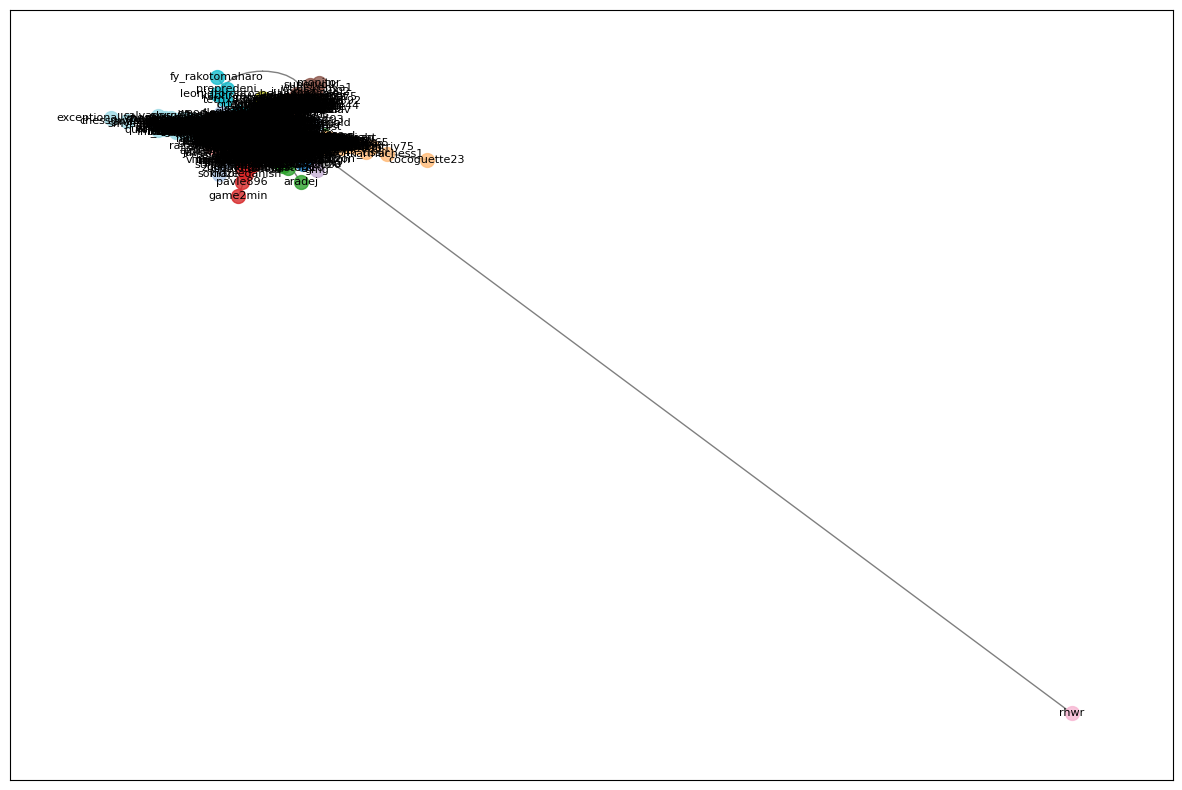

In [12]:


# color to each community for visualization
unique_communities = set(nx.get_node_attributes(graph, 'community').values())
color_map = cm.get_cmap('tab20', len(unique_communities))
norm = mcolors.Normalize(vmin=min(unique_communities), vmax=max(unique_communities))

# dictionary for mapping communities to colors
community_colors = {community: color_map(norm(community)) for community in unique_communities}

# graph with node colors based on their community
plt.figure(figsize=(15, 10))
pos = nx.spring_layout(graph)

for node, attr in graph.nodes(data=True):
    community = attr['community']
    nx.draw_networkx_nodes(graph, pos, nodelist=[node], node_color=[community_colors[community]],
                           node_size=100, alpha=0.8)

nx.draw_networkx_edges(graph, pos, alpha=0.5)
nx.draw_networkx_labels(graph, pos, font_size=8, font_color='black')

# colorbar
sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
sm.set_array([])
plt.colorbar(sm, ticks=range(len(unique_communities)), label='Community')

plt.title("Graph Visualization with Communities Highlighted")
plt.show()

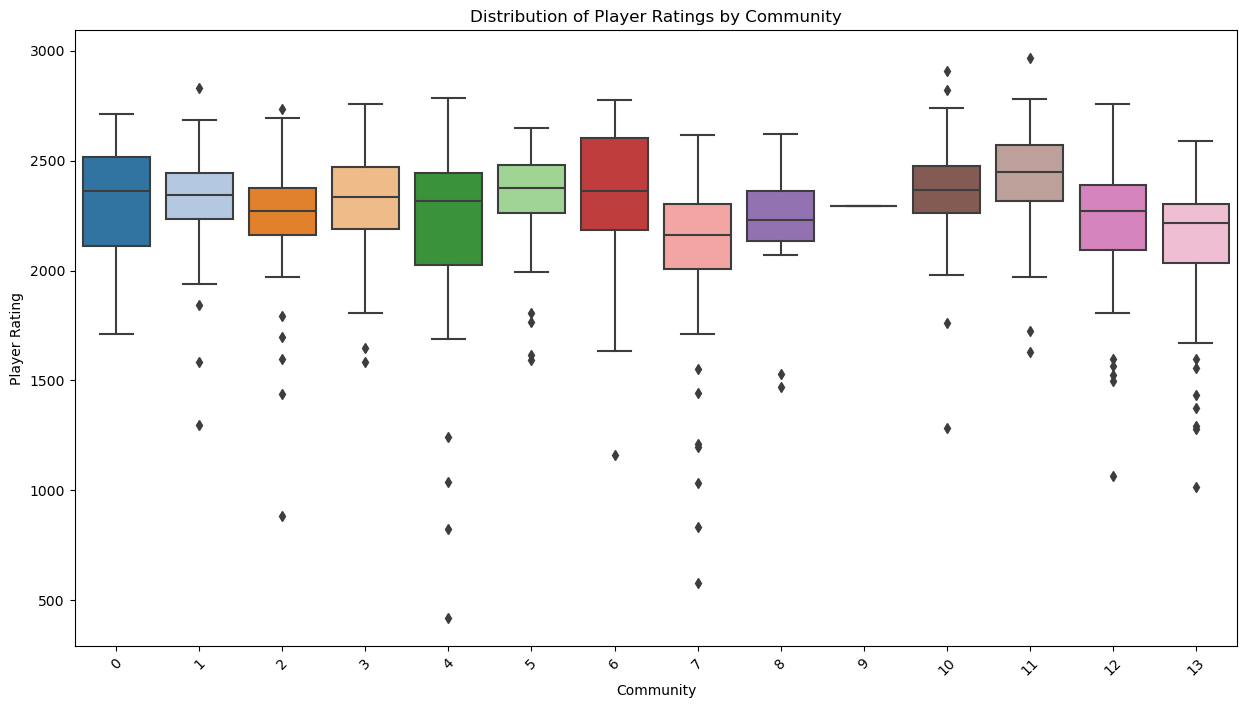

In [13]:


# extract community and rating information from the graph
community_data = []
for node, attr in graph.nodes(data=True):
    community = attr.get('community')
    rating = attr.get('rating')
    if community is not None and rating is not None:
        community_data.append({'community': community, 'rating': rating})


community_df = pd.DataFrame(community_data)


plt.figure(figsize=(15, 8))

# distributions of player ratings for each community 
sns.boxplot(x='community', y='rating', data=community_df, palette='tab20')
plt.title('Distribution of Player Ratings by Community')
plt.xlabel('Community')
plt.ylabel('Player Rating')
plt.xticks(rotation=45)
plt.show()


C:\Users\yeban\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


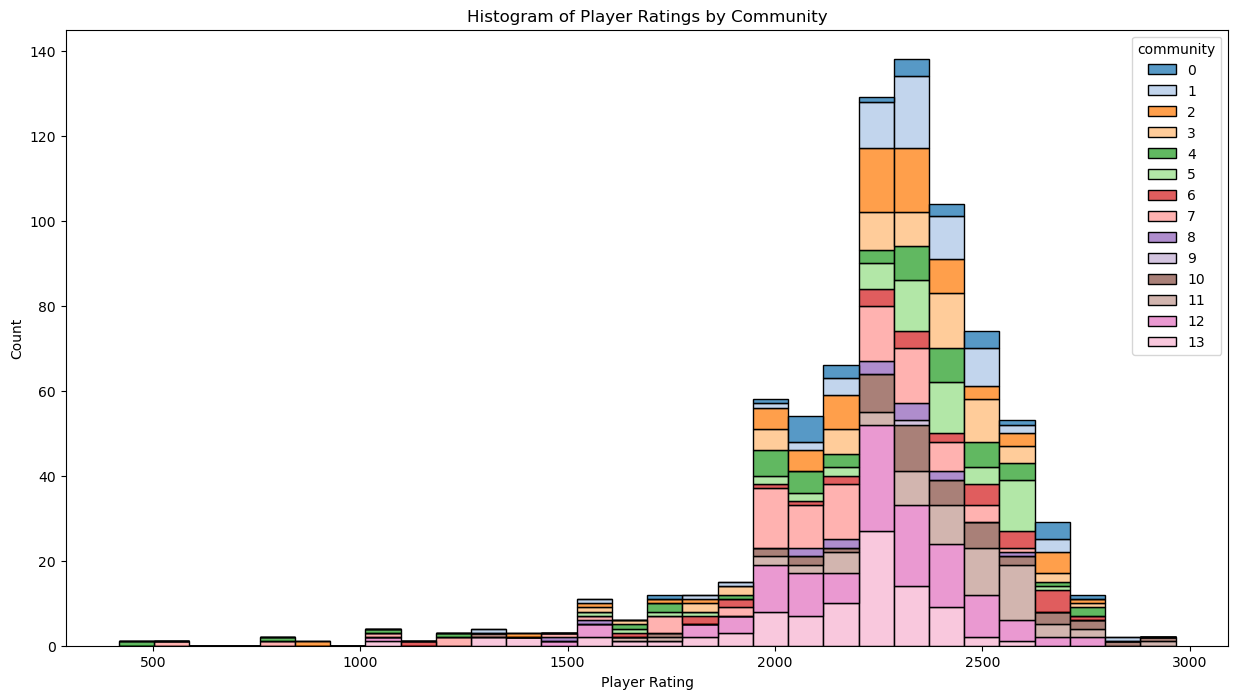

In [14]:
# histograms 
plt.figure(figsize=(15, 8))
sns.histplot(data=community_df, x='rating', hue='community', multiple='stack', palette='tab20', bins=30)
plt.title('Histogram of Player Ratings by Community')
plt.xlabel('Player Rating')
plt.ylabel('Count')
plt.show()